In [60]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [28]:
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
#perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240612/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/aligned_msl2048/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [29]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        df = df[df["orig_token"]!="X"]
        df = df[df["new_token"]!="X"]
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
    
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [30]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [31]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [32]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2500798, 17)



#### WIV04 reference sequence

In [33]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [34]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [35]:
wiv04_aligned_seq[:2049]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [36]:
wiv04_aligned_seq[2049:]

'KVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFC-GKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---------HDGKAHFPRE---GVFVS-----NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL----DSFKEELDKYFKNHTSPDVDLGDIS-GINASV--VNIQKEID--------------RLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTS-----CCS-----------CLKG------------CCSCGSCCKFD-----------EDDSEPVLKGVKLHYT--'

In [37]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [38]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,K,2234,Q,0.000000,0.000000,Human,Human,1149
1,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,F,2233,H,0.000000,0.000000,Human,Human,1148
2,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,2235,T,0.000000,0.000000,Human,Human,1150
3,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,1787,U,0.000000,0.000000,Human,Human,780
4,0.000281,0.004669,0.079043,0.002242,0.004940,0.005237,0.771312,0.132277,UniRef90_A0A8B1JBP8,Human,F,130,M,-0.008243,0.008243,Human,Human,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31521,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,S,1669,F,0.000000,0.000000,Human,Human,673
31522,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,K,2408,Z,0.000000,0.000000,Human,Human,1266
31523,0.003971,0.006221,0.015743,0.006036,0.002833,0.000422,0.876217,0.088556,UniRef90_A0A8B6RKY6,Human,A,896,Y,0.009422,0.009422,Human,Human,363
31524,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,V,1788,N,0.000000,0.000000,Human,Human,781


In [39]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [40]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,K,2234,Q,0.000000,0.000000,Human,Human,1149
1,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,F,2233,H,0.000000,0.000000,Human,Human,1148
2,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,2235,T,0.000000,0.000000,Human,Human,1150
3,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,1787,U,0.000000,0.000000,Human,Human,780
4,0.000281,0.004669,0.079043,0.002242,0.004940,0.005237,0.771312,0.132277,UniRef90_A0A8B1JBP8,Human,F,130,M,-0.008243,0.008243,Human,Human,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31521,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,S,1669,F,0.000000,0.000000,Human,Human,673
31522,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,K,2408,Z,0.000000,0.000000,Human,Human,1266
31523,0.003971,0.006221,0.015743,0.006036,0.002833,0.000422,0.876217,0.088556,UniRef90_A0A8B6RKY6,Human,A,896,Y,0.009422,0.009422,Human,Human,363
31524,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,V,1788,N,0.000000,0.000000,Human,Human,781


# Overview

### Distribution of Human class difference

In [41]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [42]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 2510 (0.1004537628538794)
Distribution of full perturbation output
n=2498662
       start       end    count  percentage
0  -0.635250 -0.588791        2    0.000080
1  -0.588791 -0.542332       12    0.000480
2  -0.542332 -0.495873       27    0.001081
3  -0.495873 -0.449413       48    0.001921
4  -0.449413 -0.402954       77    0.003082
5  -0.402954 -0.356495       83    0.003322
6  -0.356495 -0.310036      119    0.004763
7  -0.310036 -0.263577      119    0.004763
8  -0.263577 -0.217118      145    0.005803
9  -0.217118 -0.170659      211    0.008445
10 -0.170659 -0.124199      535    0.021411
11 -0.124199 -0.077740     1848    0.073960
12 -0.077740 -0.031281    18076    0.723427
13 -0.031281  0.015178  2436825   97.525195
14  0.015178  0.061637    38528    1.541945
15  0.061637  0.108096     1655    0.066235
16  0.108096  0.154555      240    0.009605
17  0.154555  0.201015       90    0.003602
18  0.201015  0.247474       20   

<Figure size 432x288 with 0 Axes>

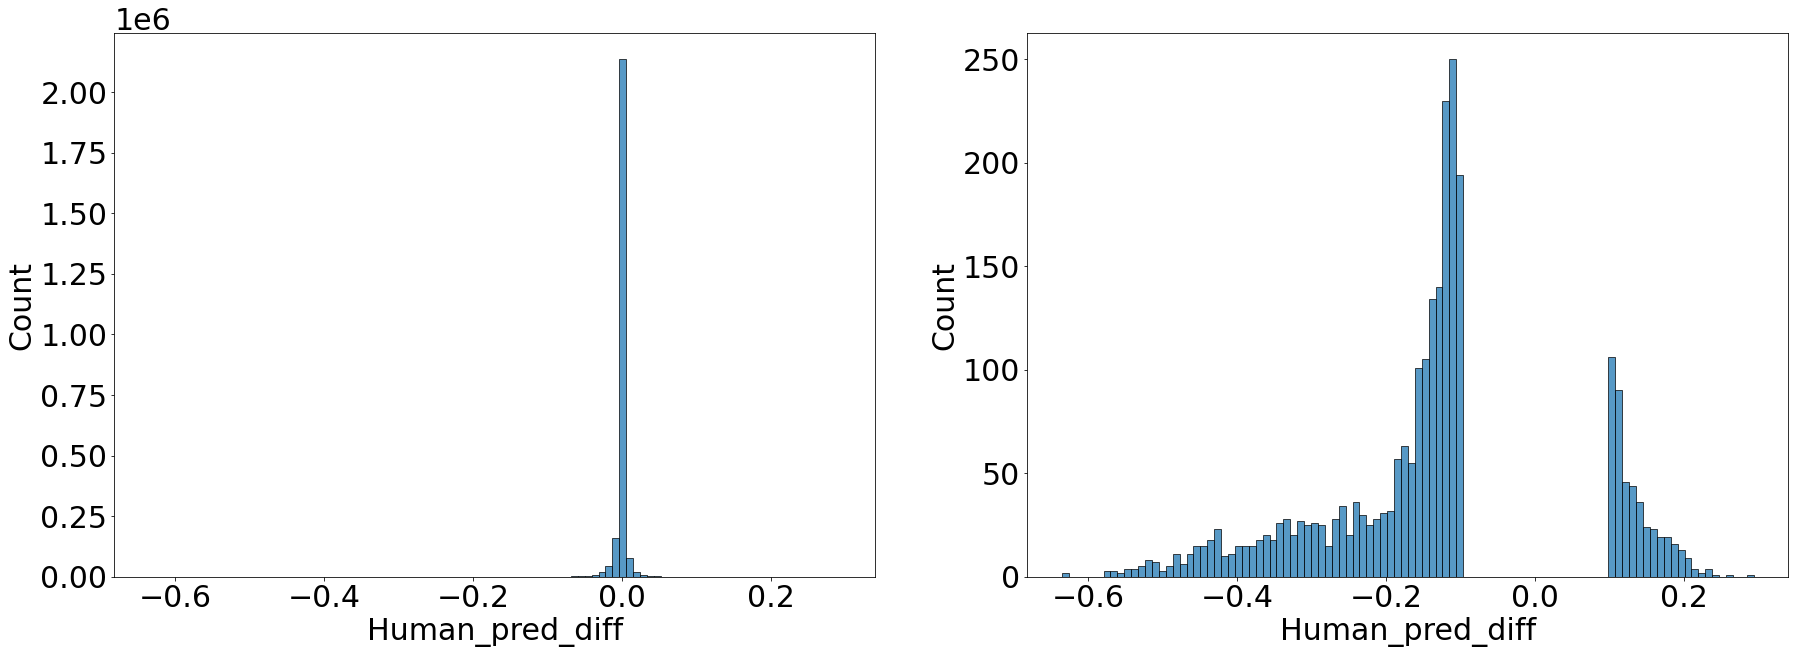

In [43]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

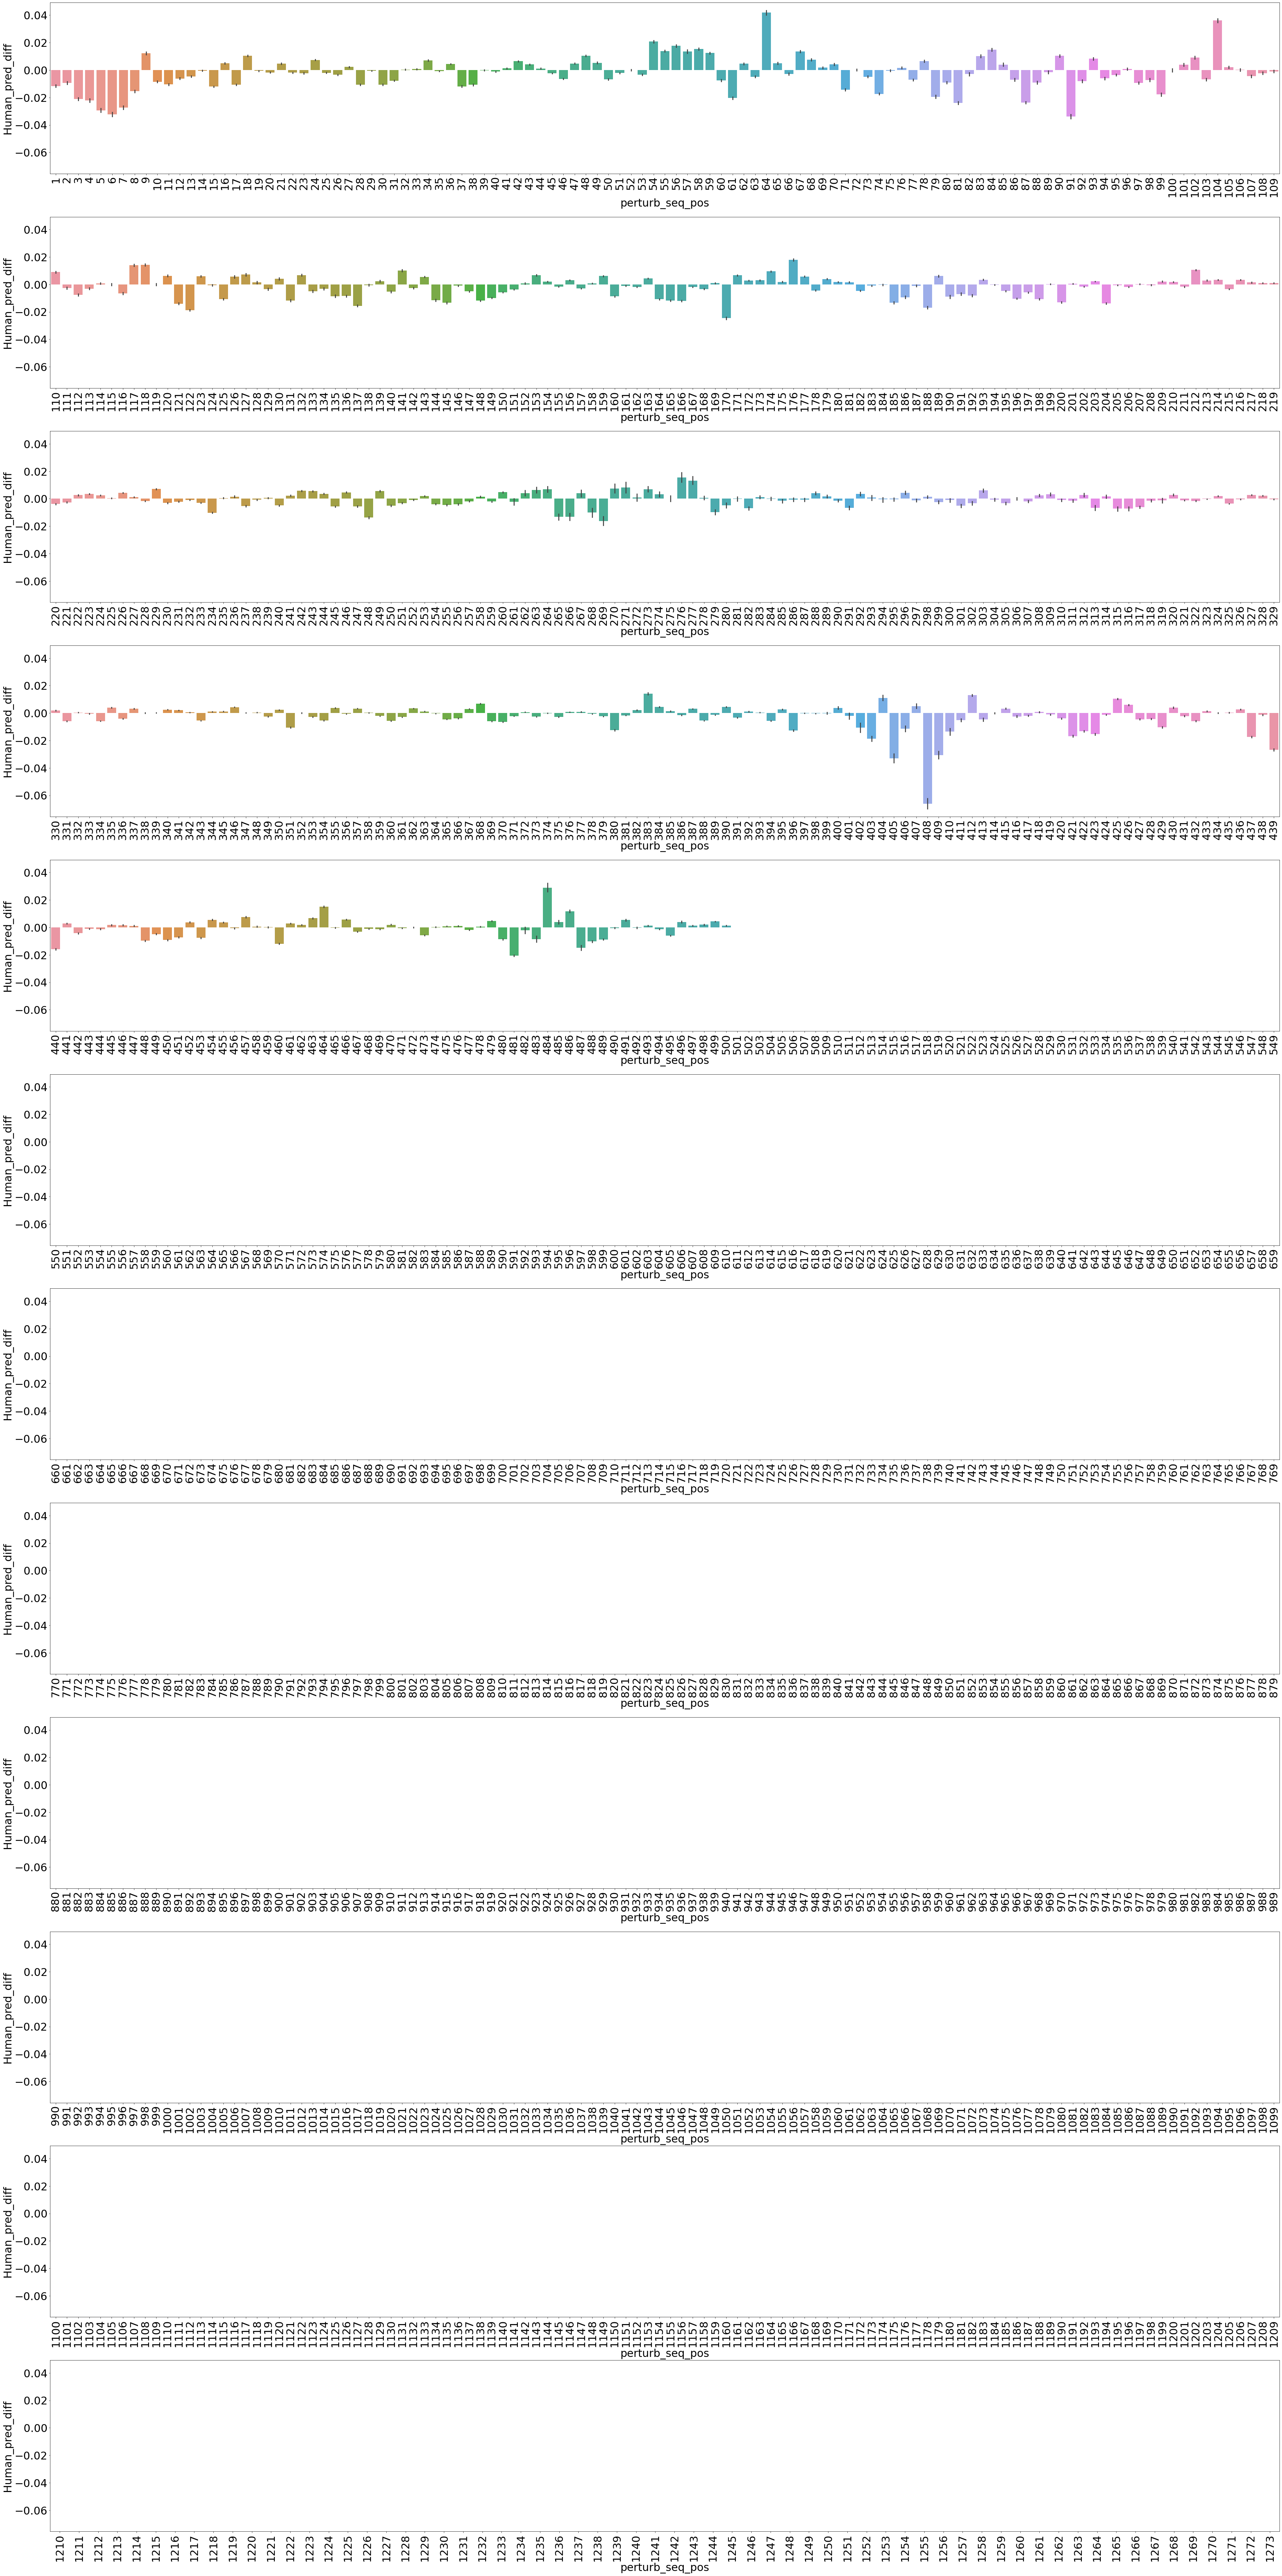

In [44]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

In [45]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
31825,0.000044,0.002128,0.045426,0.000212,0.000493,0.003066,0.928802,0.019829,UniRef90_A0A899K156,Human,V,1728,G,-1.700000e-07,1.700000e-07,Human,Human,722
30768,0.000948,0.001538,0.101887,0.008749,0.002986,0.009851,0.546510,0.327531,UniRef90_A0A8B6RMB3,Human,T,2217,Y,-1.200000e-07,1.200000e-07,Human,Human,1136
30769,0.000948,0.001538,0.101887,0.008749,0.002986,0.009851,0.546510,0.327531,UniRef90_A0A8B6RMB3,Human,N,2086,F,-1.200000e-07,1.200000e-07,Human,Human,1023
30770,0.000948,0.001538,0.101887,0.008749,0.002986,0.009851,0.546510,0.327531,UniRef90_A0A8B6RMB3,Human,D,1805,F,-1.200000e-07,1.200000e-07,Human,Human,796
30771,0.000948,0.001538,0.101887,0.008749,0.002986,0.009851,0.546510,0.327531,UniRef90_A0A8B6RMB3,Human,I,1666,K,-1.200000e-07,1.200000e-07,Human,Human,670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31825,0.000339,0.002110,0.057670,0.001883,0.001290,0.003476,0.842525,0.090706,UniRef90_A0A8B6RF44,Human,N,2016,L,-2.000000e-07,2.000000e-07,Human,Human,955
31824,0.000032,0.001131,0.109734,0.000338,0.000490,0.009561,0.843318,0.035395,UniRef90_A0A7U3DWG5,Human,P,1678,L,2.500000e-07,2.500000e-07,Human,Human,681
31825,0.000032,0.001131,0.109734,0.000338,0.000490,0.009561,0.843318,0.035395,UniRef90_A0A7U3DWG5,Human,V,2054,I,2.500000e-07,2.500000e-07,Human,Human,991
31824,0.000181,0.004378,0.080659,0.001419,0.003293,0.005256,0.805225,0.099589,UniRef90_A0A899KK42,Human,E,1600,C,-4.000000e-08,4.000000e-08,Human,Human,619


### Cut-off: mean=0 and variance=0

In [46]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

577

<Figure size 432x288 with 0 Axes>

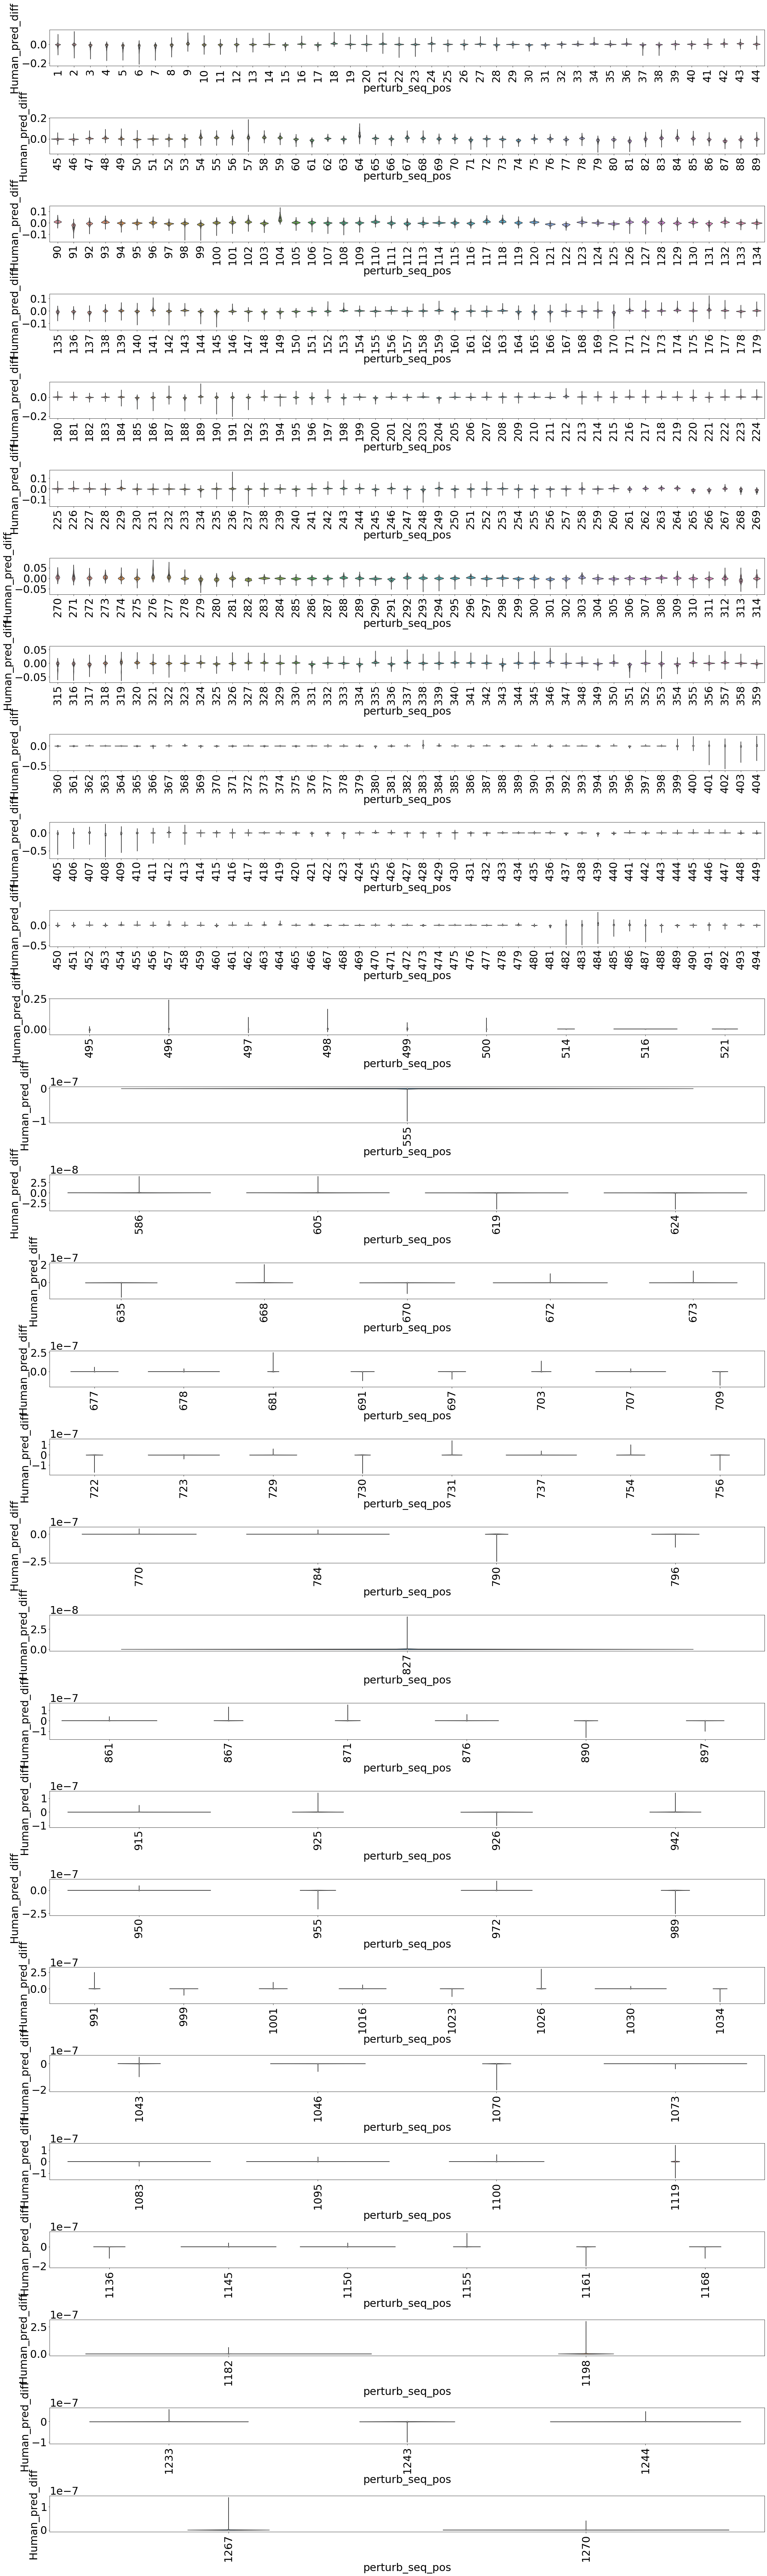

In [47]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(29, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 1273, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [48]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 577
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 82
1 intersection 2: 82
1 minus 2: 495
2 minus 1: 0
is 2 subset of 1: True


In [49]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

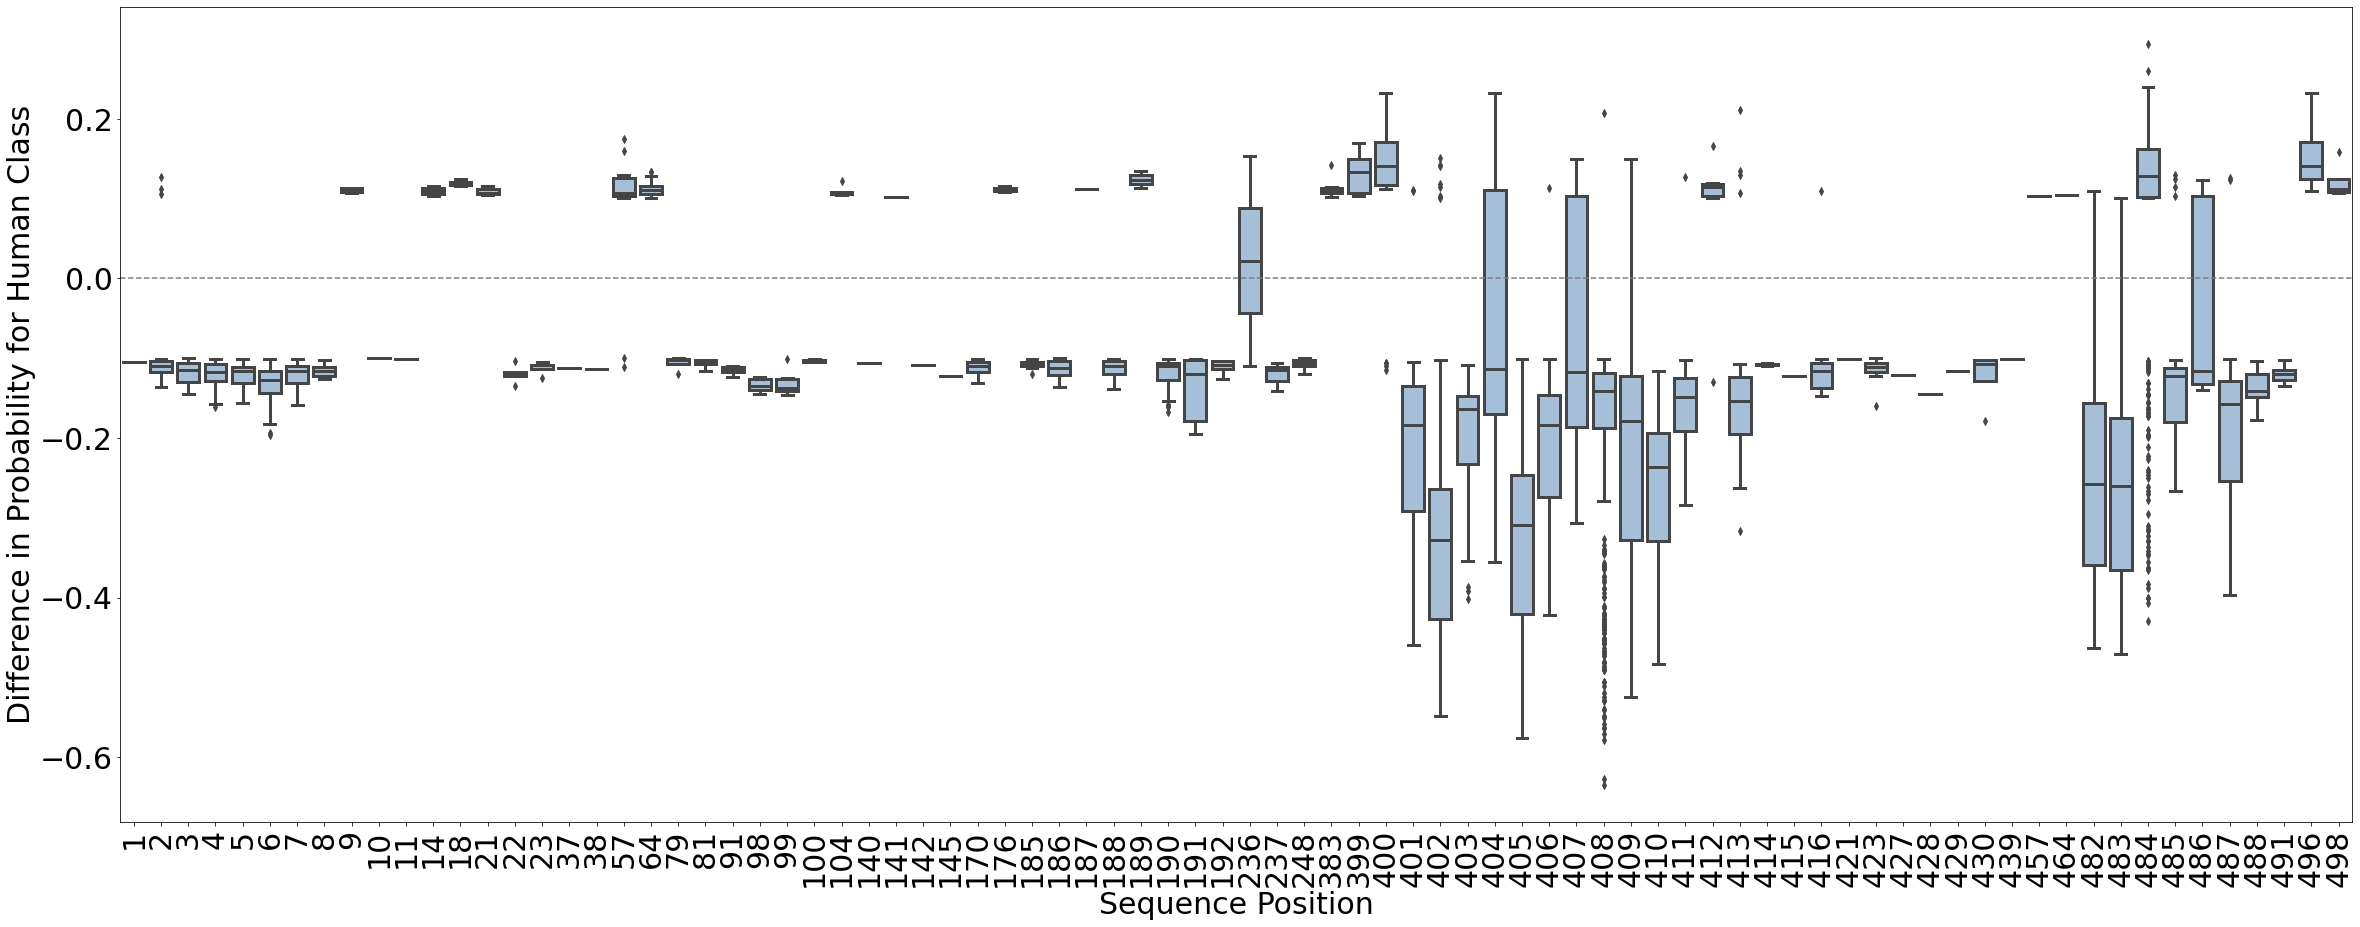

In [65]:
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(40, 15), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), 1)

for i in range(1):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs, orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs.tick_params(axis='x', rotation=90)
    axs.axhline(0.0, color="gray", linestyle="--")
    axs.set_ylabel("Difference in Probability for Human Class")
    axs.set_xlabel("Sequence Position")
#plt.show()
plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/visualization/temp/perturbation_analysis_important_positions.pdf"))
plt.show()


### Important positions causing class change from Human

3374
4.060462359217546


<Figure size 432x288 with 0 Axes>

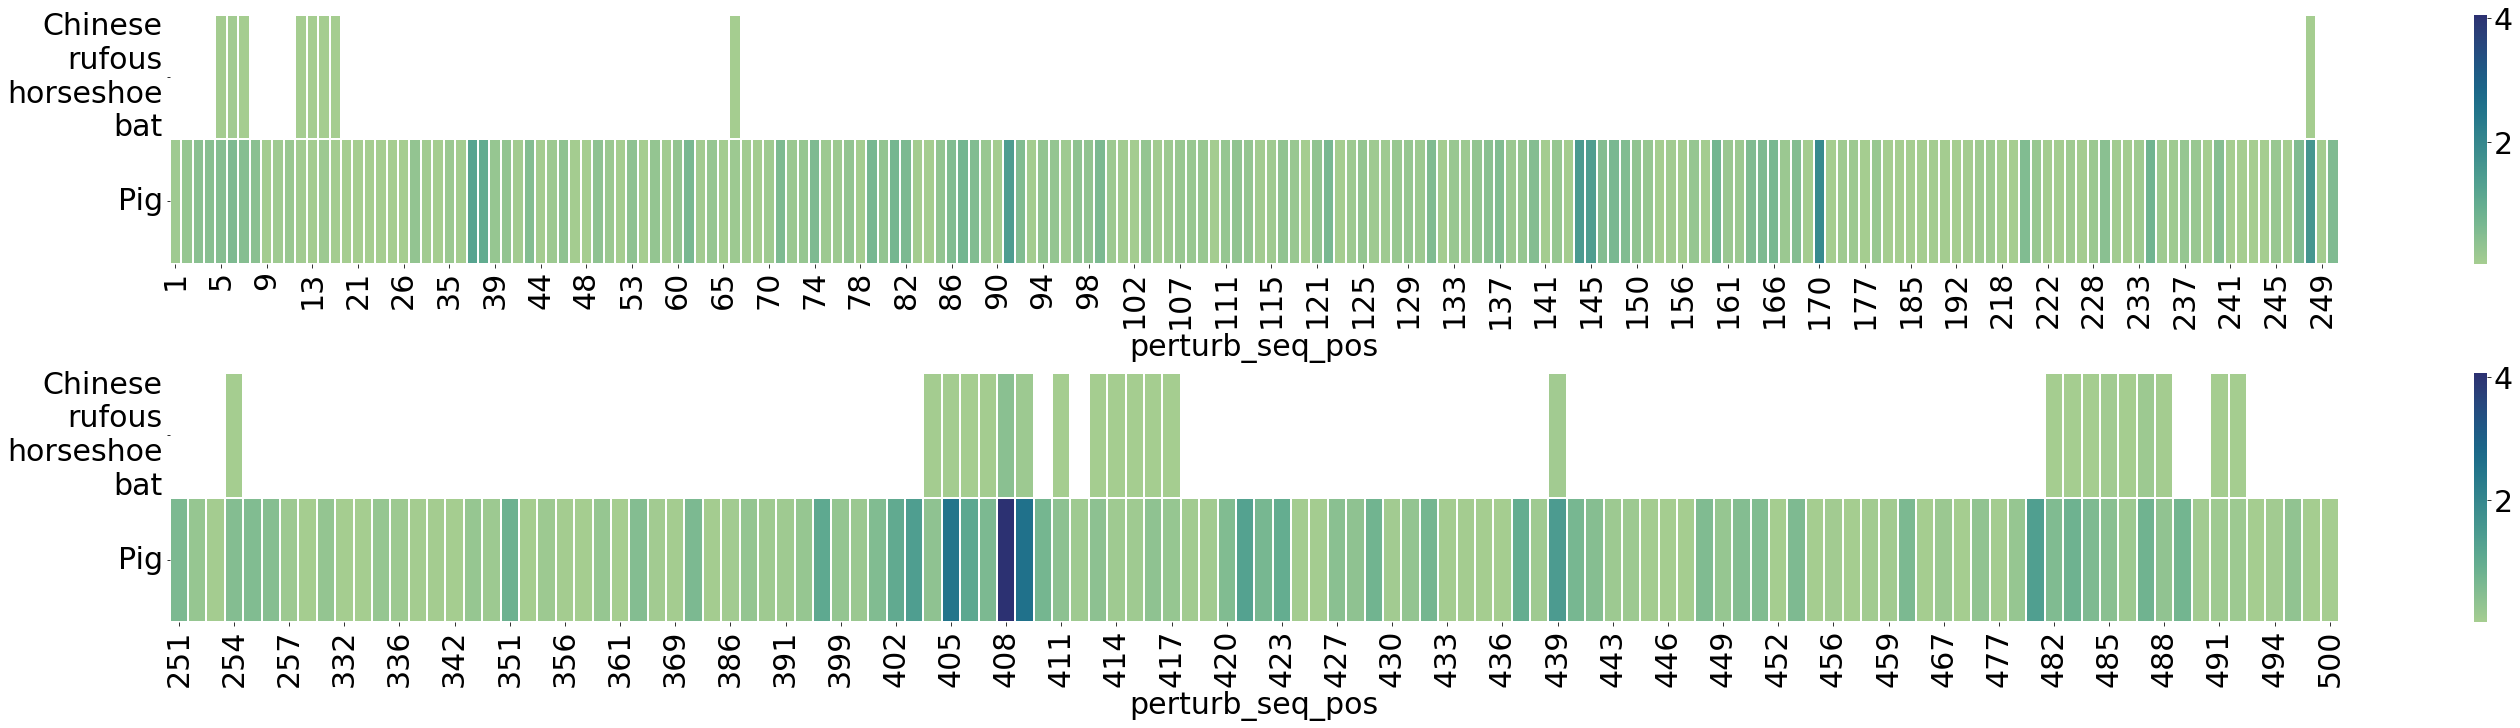

In [51]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

469


<Figure size 432x288 with 0 Axes>

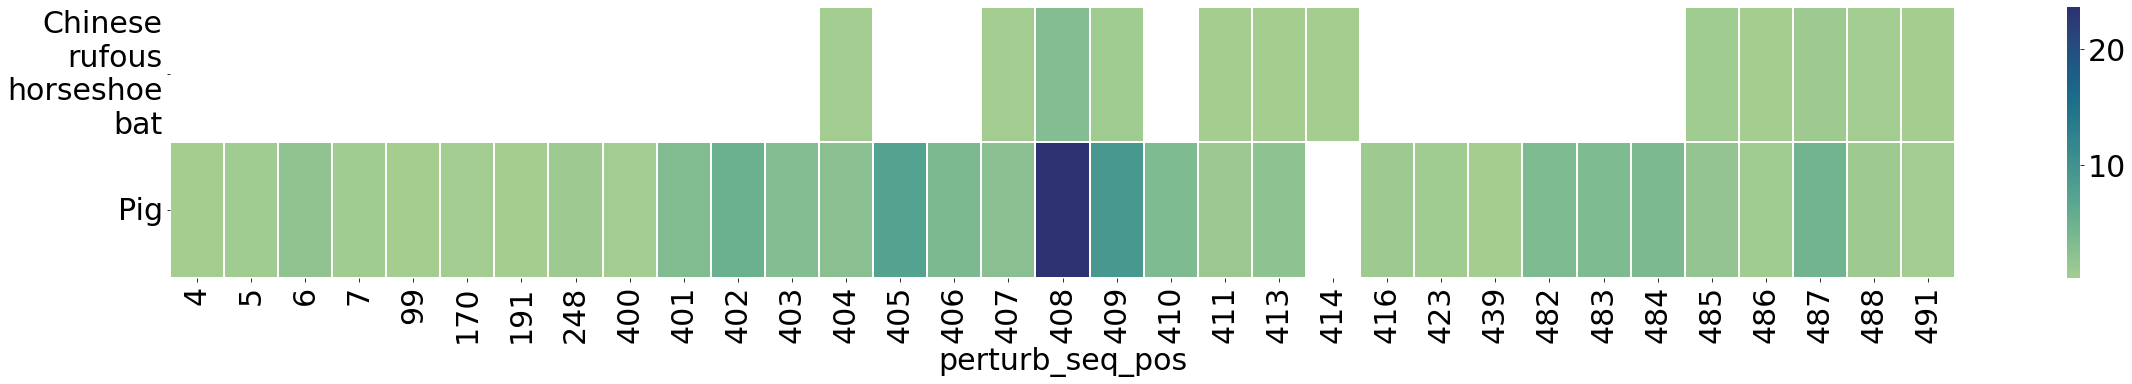

In [52]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

In [53]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
print(f"Number of unique mutations = {cut_off_df_2['perturbation_id'].nunique()}")
annotate_df_pos = cut_off_df_2.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = cut_off_df_2.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

Number of unique mutations = 313


/tmp/ipykernel_969293/1469307901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


<Figure size 432x288 with 0 Axes>

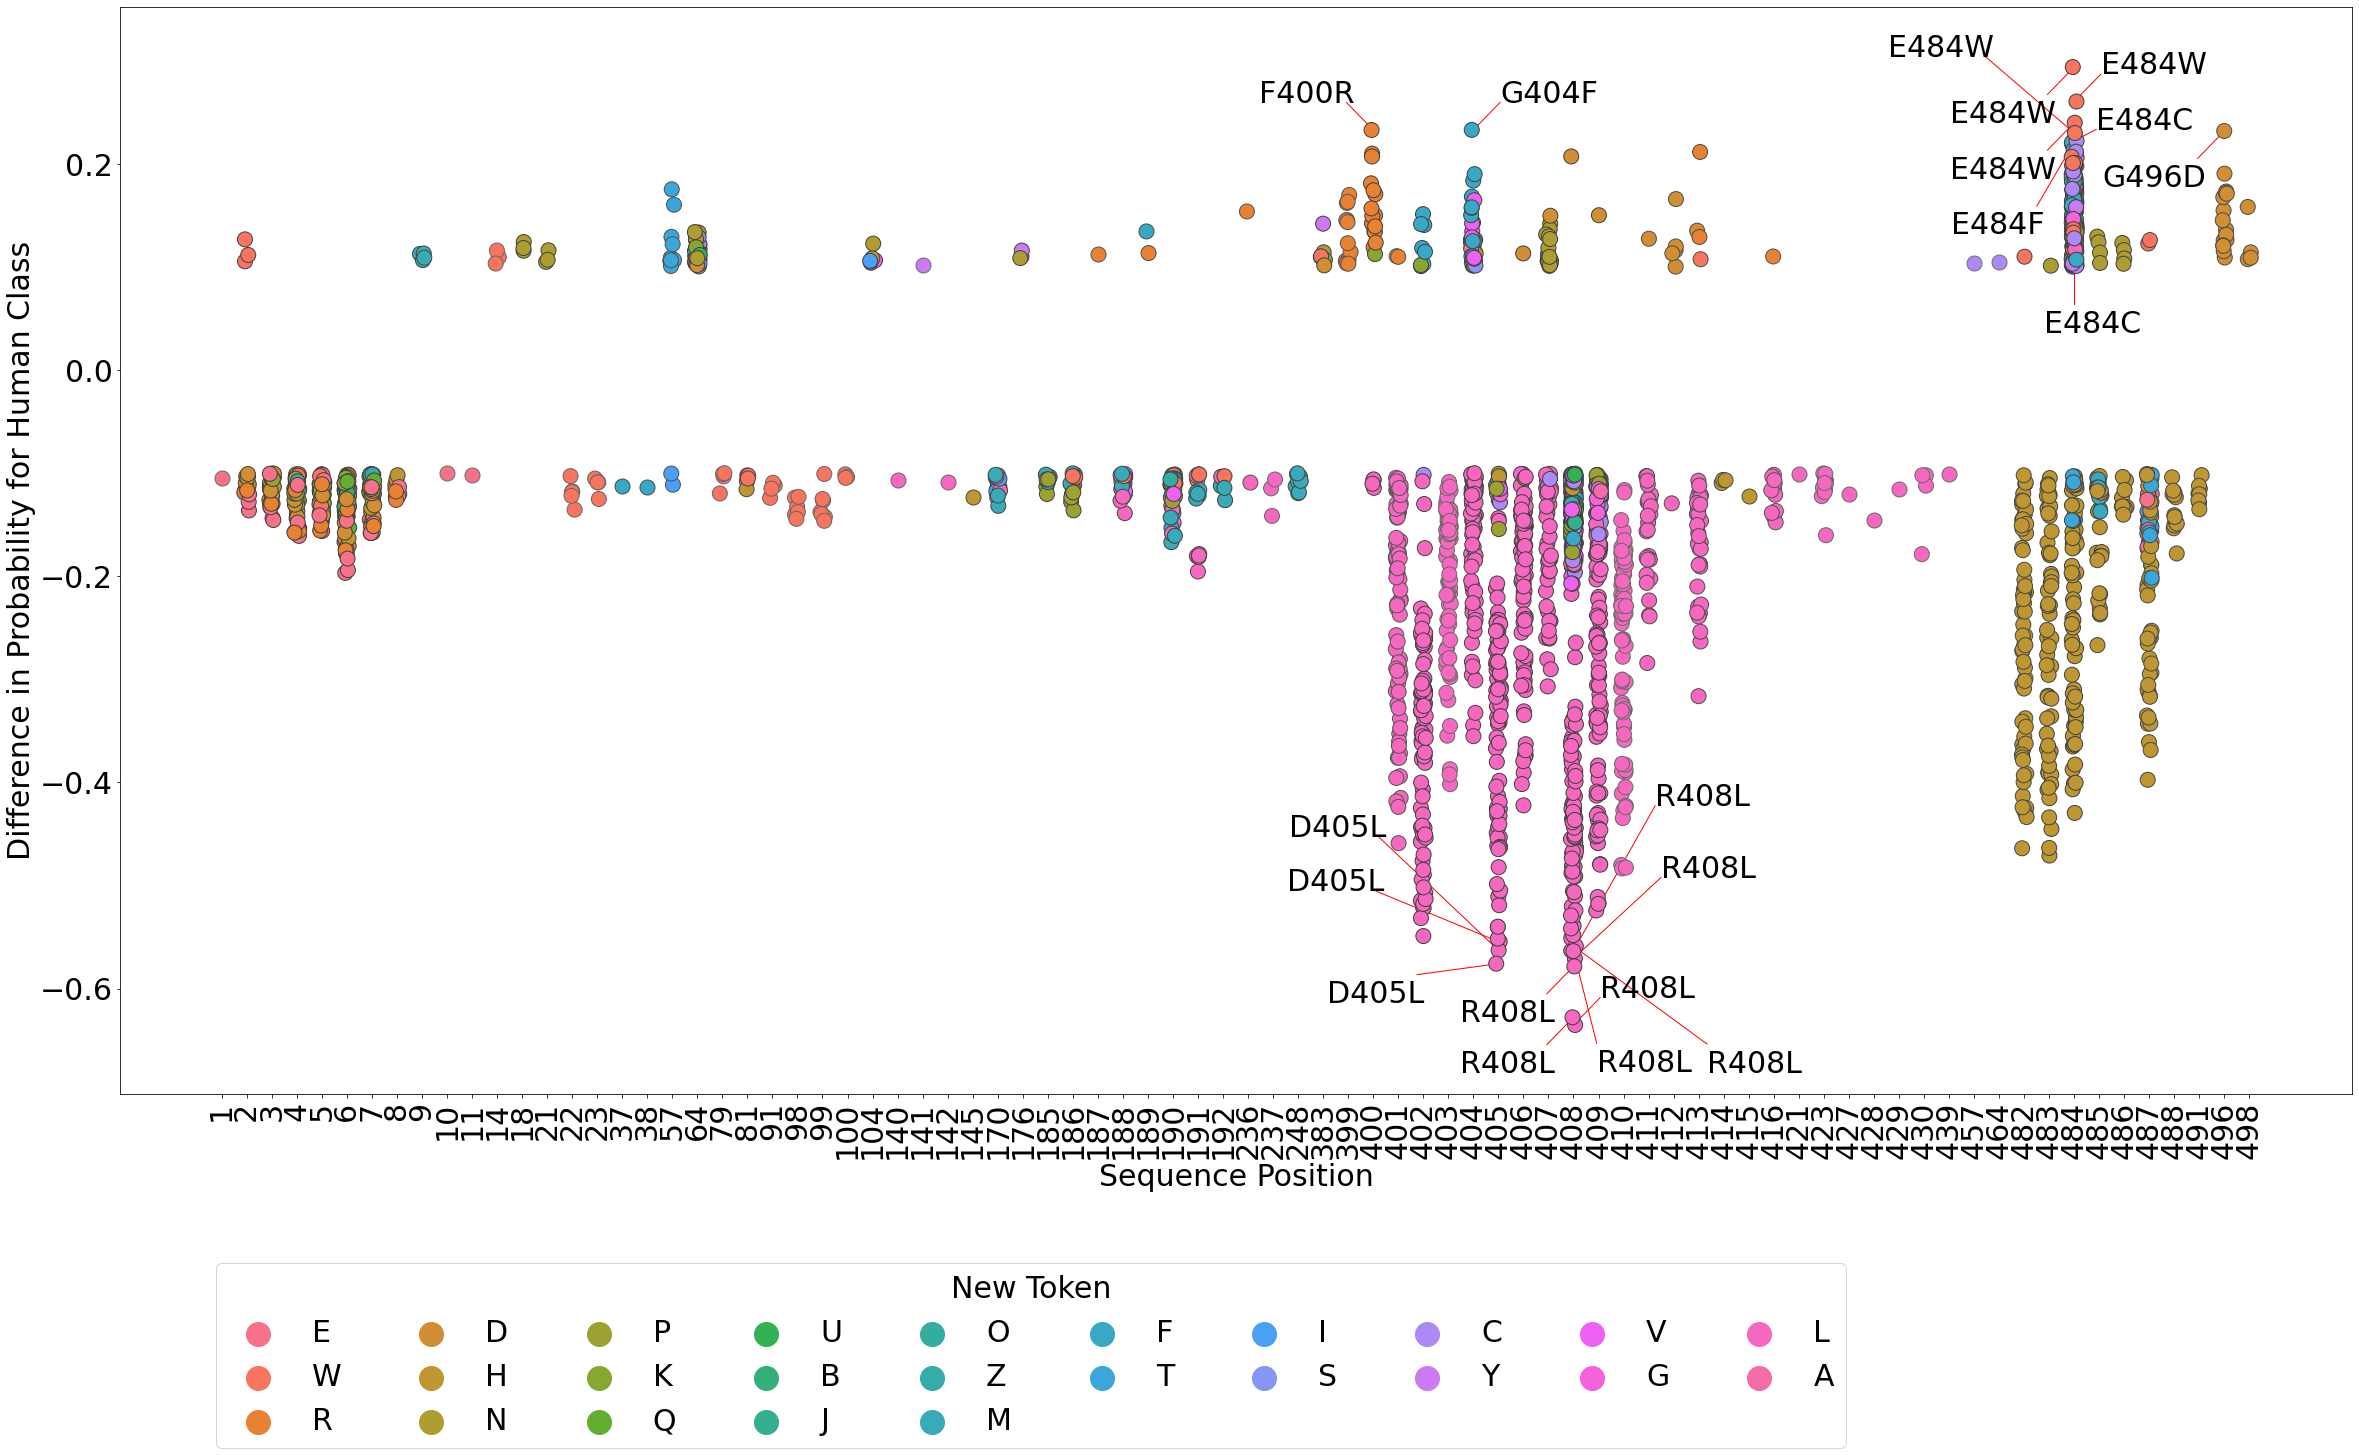

In [68]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=cut_off_df_2, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in cut_off_df_2["perturb_seq_pos"].values], 
            y_scatter=cut_off_df_2[pred_diff_col].values, textsize=30)
ax.set_ylabel("Difference in Probability for Human Class")
ax.set_xlabel("Sequence Position")
ax.figure.canvas.draw()
plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/visualization/temp/perturbation_analysis_important_mutations.pdf"))
plt.show()


In [55]:
cut_off_df_2["perturbation_id"].nunique()

313

<Figure size 432x288 with 0 Axes>

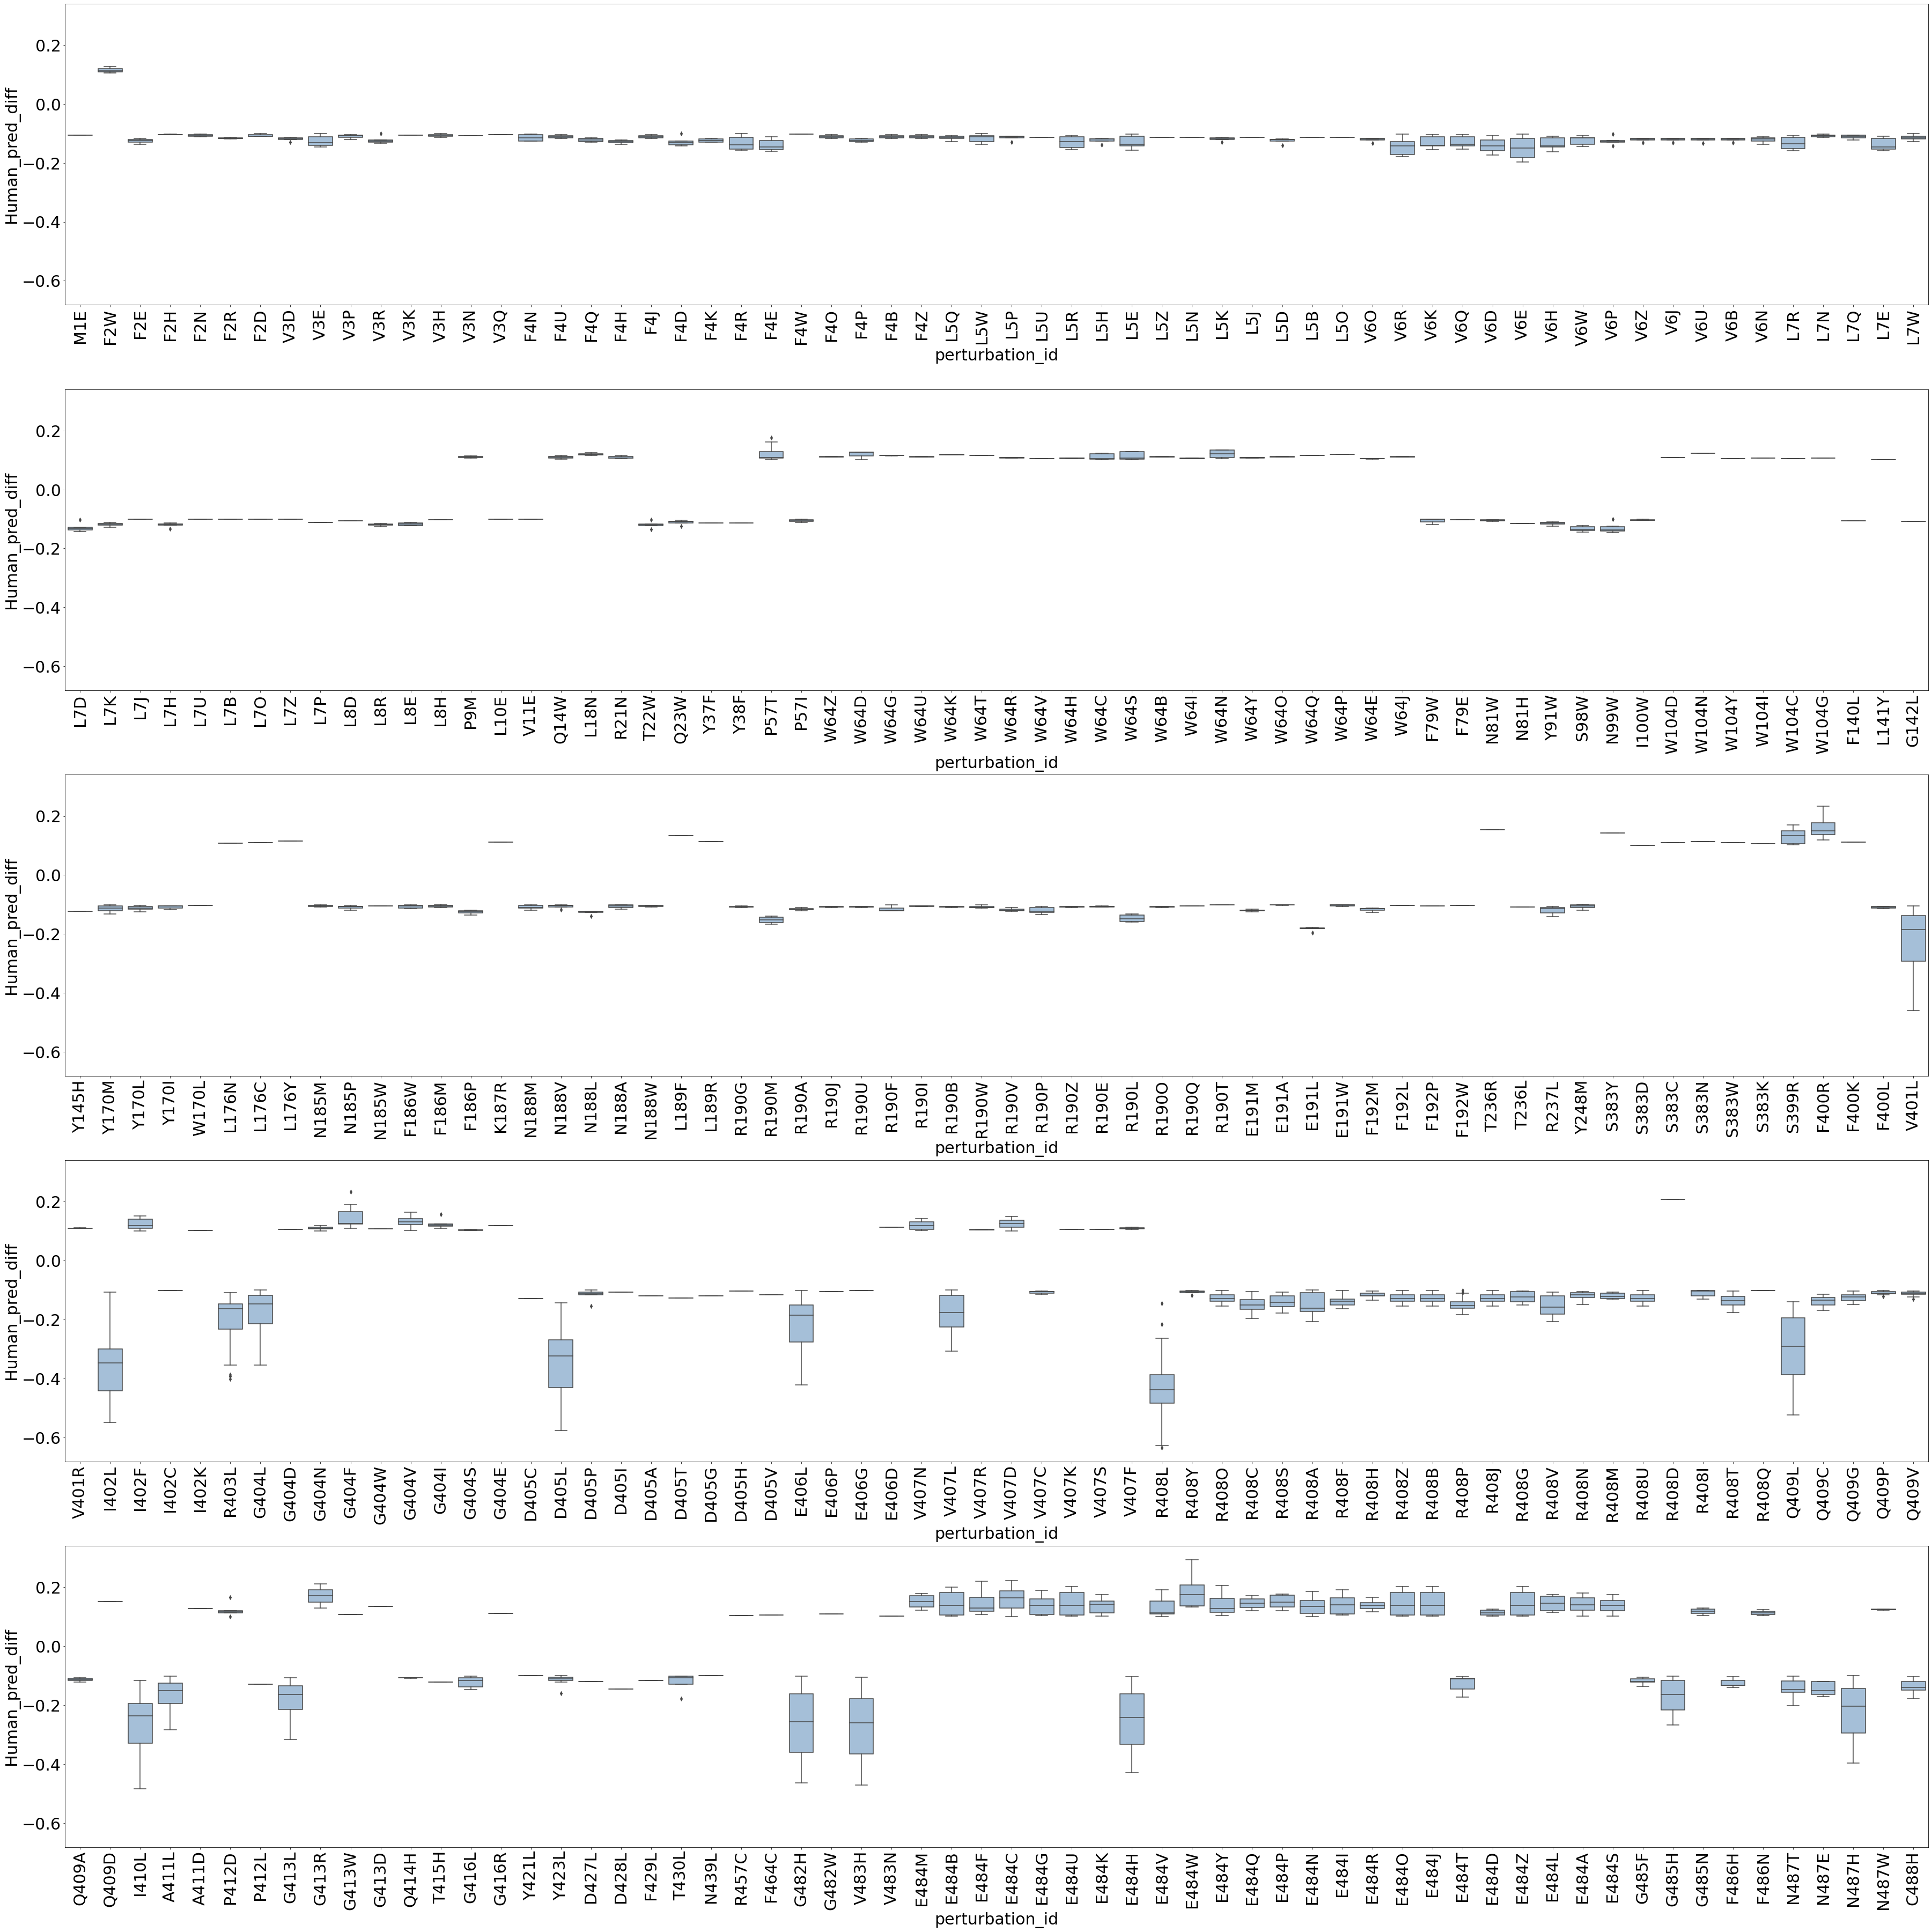

In [56]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(5, 1, figsize=(50, 50), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), 5)

j = 0
for i in range(5):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [33]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,orig_token,pos,new_token,perturbation_id
0,D,614,G,D614G
1,S,943,P,S943P
2,E,484,K,E484K
3,N,501,Y,N501Y
4,L,452,R,L452R
5,Q,677,P,Q677P
6,Q,677,H,Q677H
7,P,681,H,P681H
8,E,484,Q,E484Q
9,K,417,N,K417N


In [34]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_2022545/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [35]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

,orig_token,pos,new_token,perturbation_id,label
0,D,614,G,D614G,D614G (n=2 | 2.13%)
1,S,943,P,S943P,S943P (n=93 | 98.94%)
2,E,484,K,E484K,E484K (n=83 | 88.30%)
3,N,501,Y,N501Y,N501Y (n=85 | 90.43%)
4,L,452,R,L452R,L452R (n=30 | 31.91%)
5,Q,677,P,Q677P,Q677P (n=88 | 93.62%)
6,Q,677,H,Q677H,Q677H (n=88 | 93.62%)
7,P,681,H,P681H,P681H (n=91 | 96.81%)
8,E,484,Q,E484Q,E484Q (n=83 | 88.30%)
9,K,417,N,K417N,K417N (n=89 | 94.68%)


<Figure size 432x288 with 0 Axes>

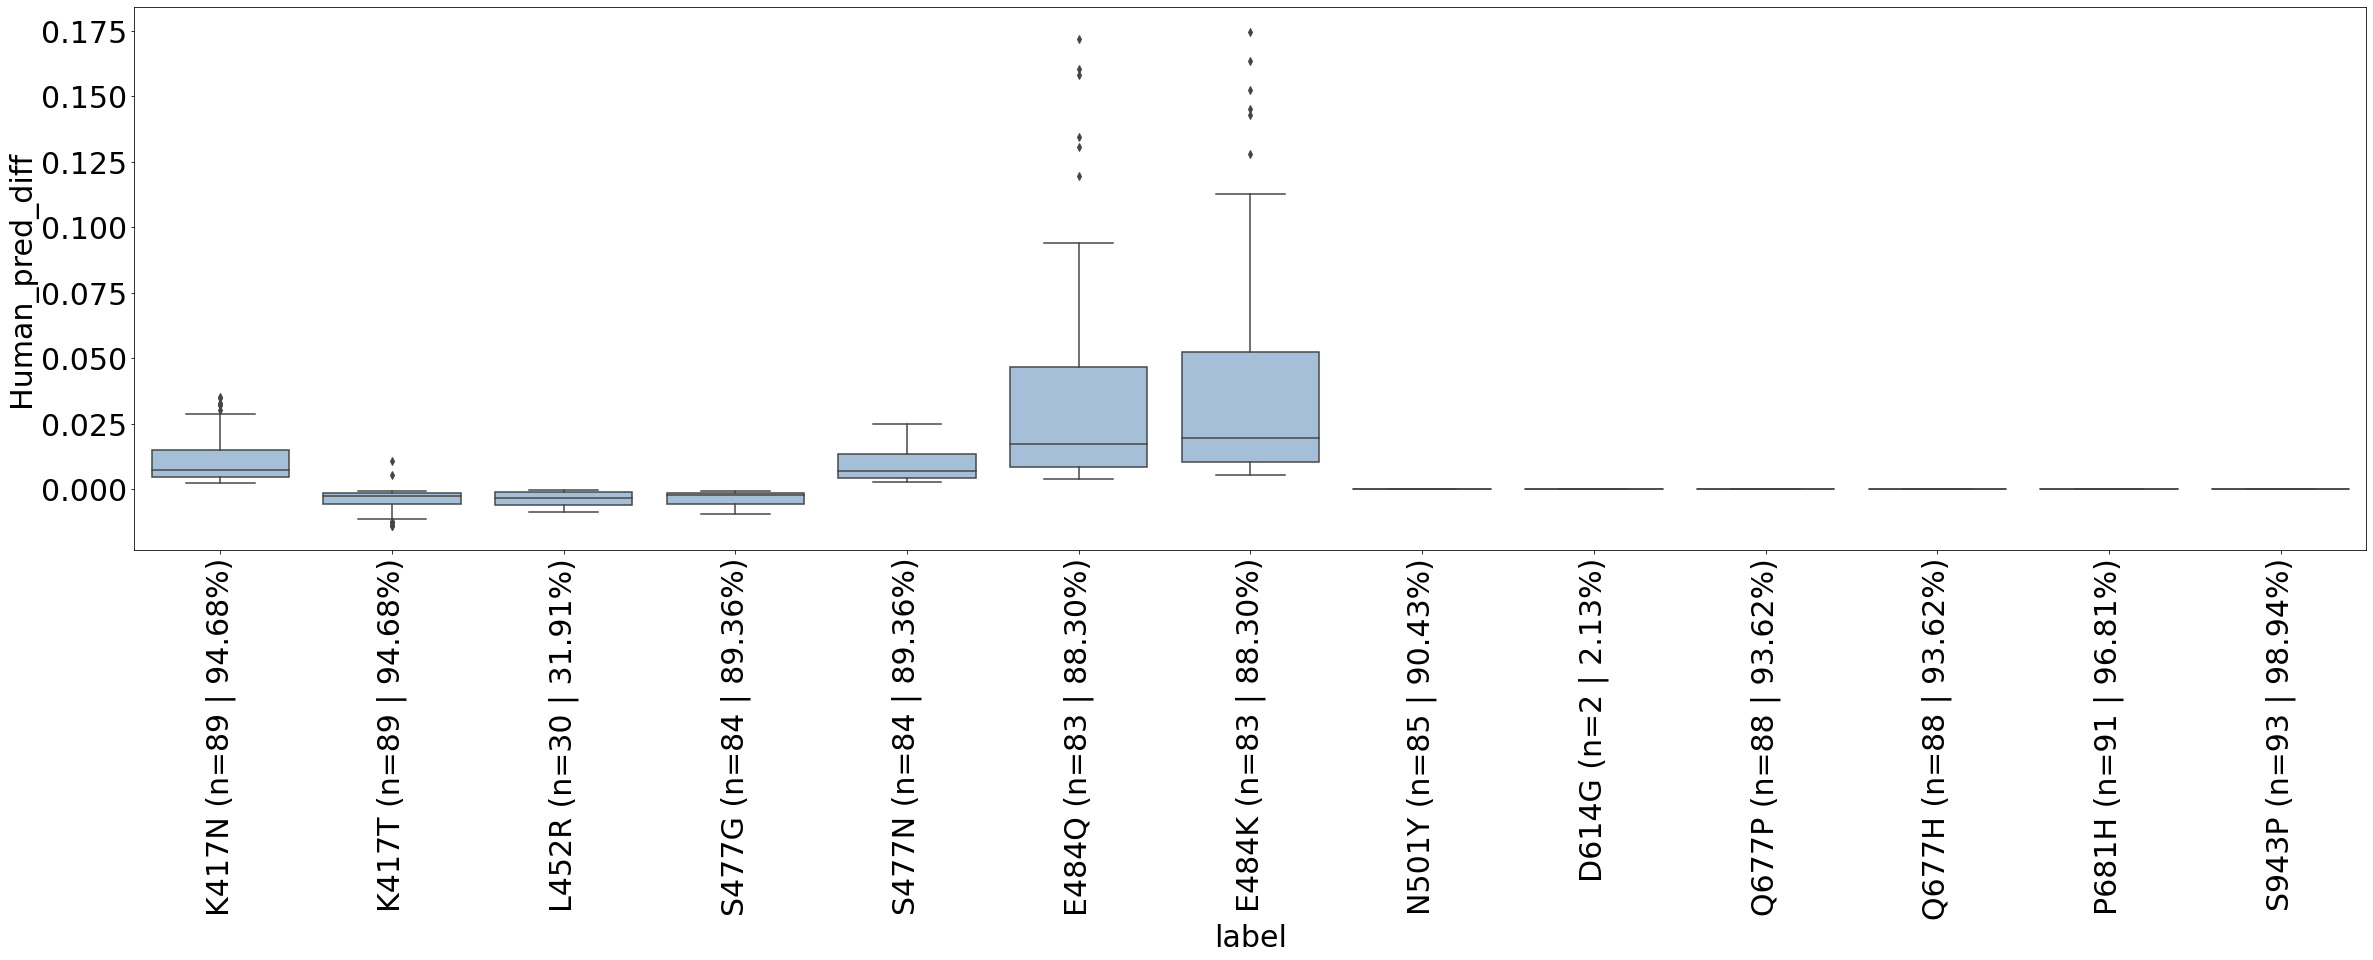

In [36]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [37]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 313
known_mutations = 13
intersection = {'E484Q', 'E484K'}


Perturbation id = E484Q
E484X
Perturbation id = E484K
E484X


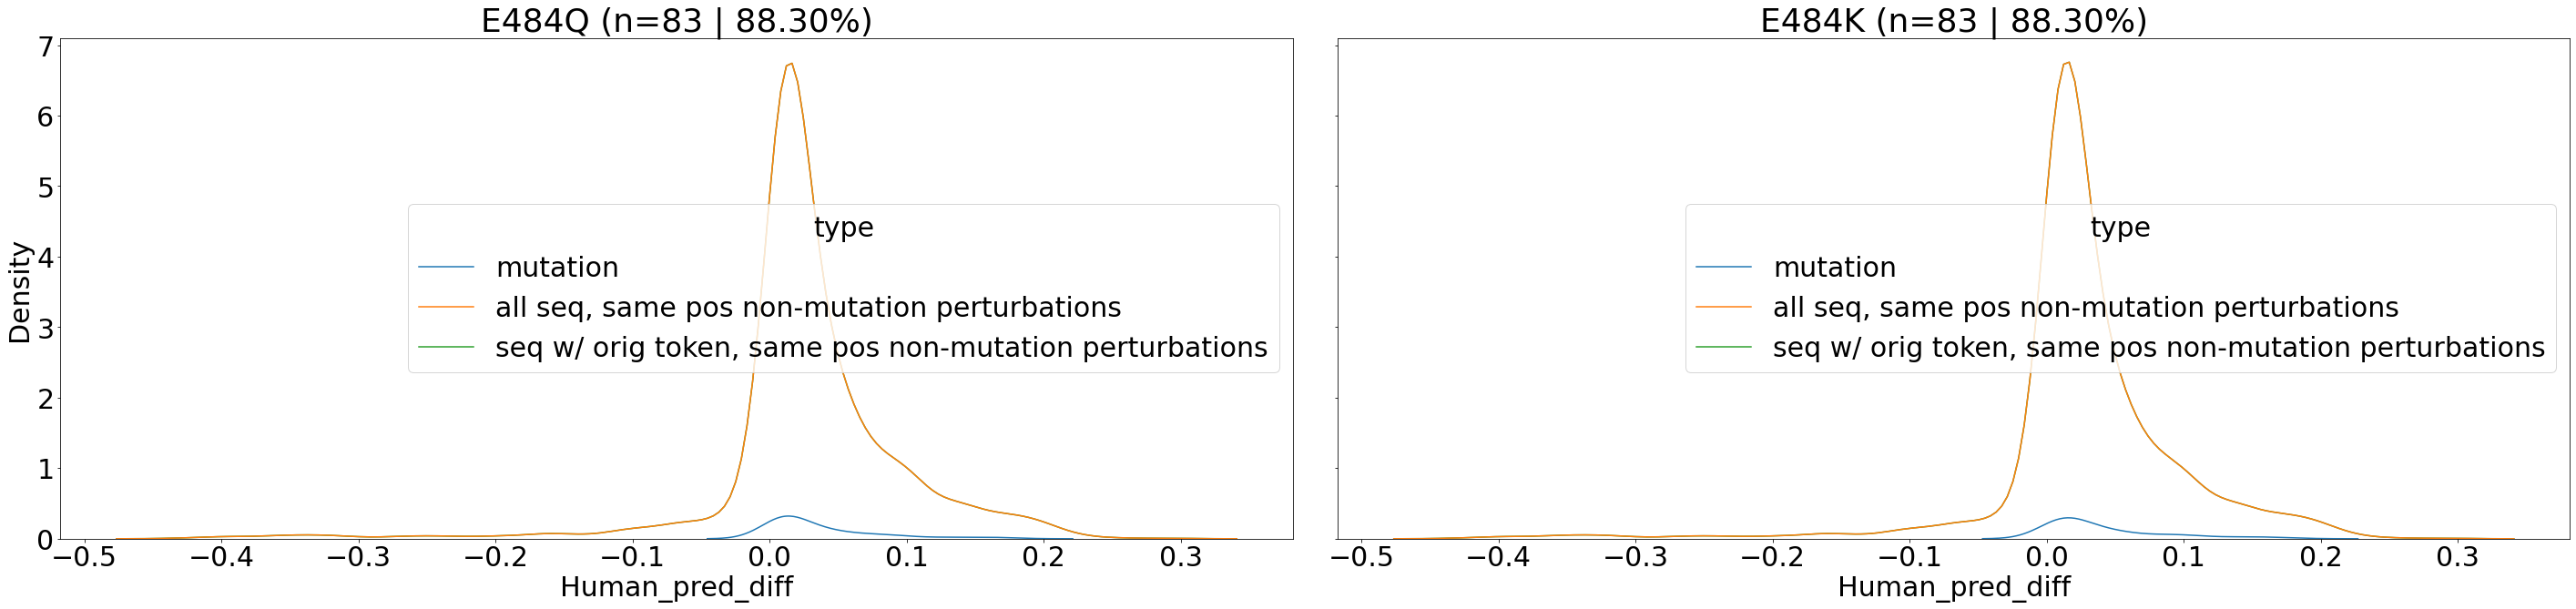

In [38]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

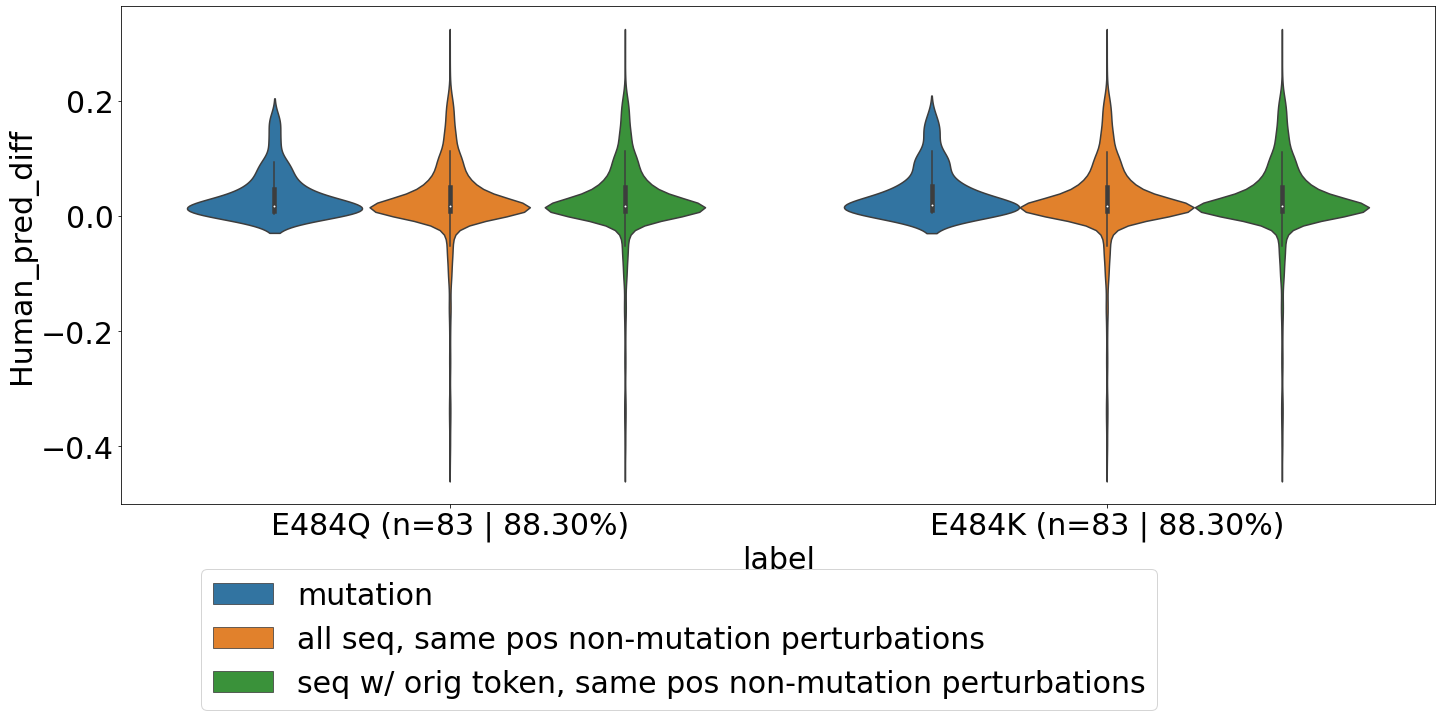

In [39]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

<Figure size 432x288 with 0 Axes>

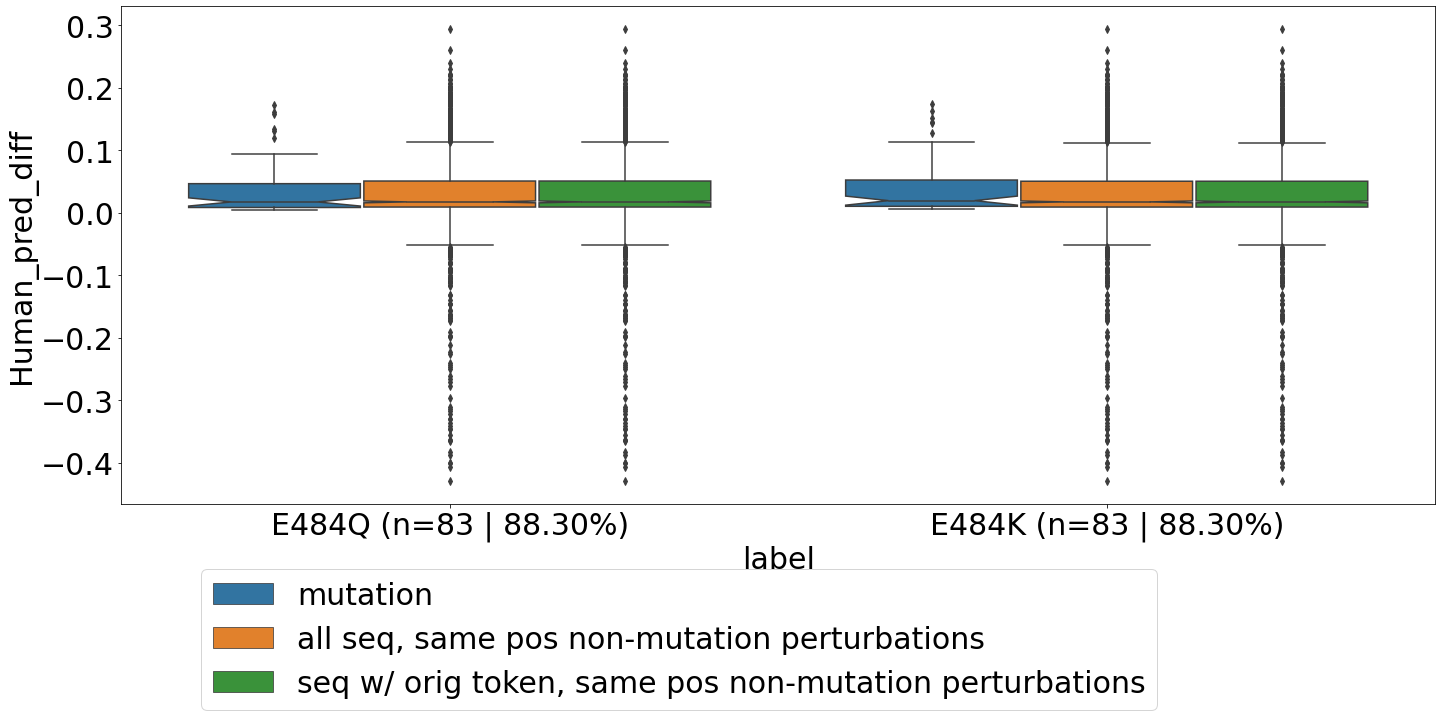

In [40]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()